# Clustering Urban Areas

This notebook shows how tessellation can be used to generate clustering units in order to segment urban areas.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (8,8)

import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, MultiPoint
import contextily as ctx

In [2]:
# Shapely 1.8.1 makes pandas to produce many warnings; this is to get rid of these warnings
import warnings
warnings.simplefilter("ignore")

In [3]:
from tesspy import Tessellation

## Area

We use **Frankfurt am Main** in Germany as a case study. First we get the city boundry. Then we generate different tessellations. 

In [4]:
ffm= Tessellation('Frankfurt am Main')
ffm_polygon=ffm.get_polygon()

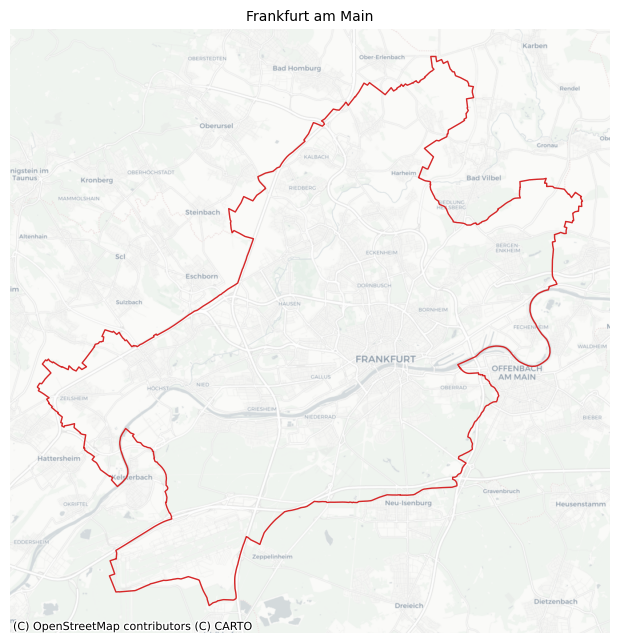

In [5]:
# visualization of area
ax= ffm_polygon.to_crs('EPSG:3857').plot(facecolor='none', edgecolor='tab:red',lw=1)
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
ax.set_title('Frankfurt am Main', fontsize=10)
plt.show()

## Tessellation

In [1]:
from time import sleep

In [2]:
sleep(120)

In [ ]:
poi_categories=['shop','building','amenity','office','public_transport']

# squares
ffm_sqr_16=ffm.squares(16)
# hexagons
ffm_hex_9=ffm.hexagons(9)
# adaptive squares
ffm_asq = ffm.adaptive_squares(start_resolution=13, threshold=500, timeout=60,poi_categories=poi_categories)
# voronoi Diagrams with K-Means
ffm_voronoi_kmeans= ffm.voronoi(poi_categories=poi_categories, n_polygons=1000)
# voronoi Diagrams with hdbscan
ffm_voronoi_hdbscan = ffm.voronoi(cluster_algo='hdbscan',min_cluster_size=10,poi_categories=poi_categories)
# city blocks
ffm_cb = ffm.city_blocks(n_polygons=1000, detail_deg=None)

In [ ]:
ffm_dfs=[ffm_sqr_16,ffm_asq, ffm_hex_9,ffm_voronoi_kmeans,ffm_voronoi_hdbscan,ffm_cb]
titles=['Squares','Adaptive Squares','Hexagons','Voronoi Polygons (K-Means)','Voronoi Polygons (HDBSCAN)','City Blocks']

fig,axs=plt.subplots(2,3, figsize=(15,10))
for ax, df, title in zip(axs.flatten(),ffm_dfs, titles) :
    ax.set_axis_off()
    df.plot(ax=ax,facecolor='none', edgecolor='k', lw=0.1)
    ax.set_title(f'\n{title} (n={len(df)})')
    
plt.tight_layout()
plt.show()

In [ ]:
# Calculate Areas

for df in ffm_dfs:
    df['area']=df.to_crs('EPSG:5243').area

In [ ]:
poi_df= ffm.get_poi_data()
poi_geodata=gpd.GeoDataFrame(data=poi_df.drop(columns=['geometry']),
                              geometry=poi_df[['center_longitude','center_latitude']].apply(Point, axis=1).values,
                              crs='EPSG:4326')

In [ ]:
# adding an ID to polygons
for df in ffm_dfs:
    df.reset_index(inplace=True)
    df.rename(columns={'index':'tile_id'}, inplace=True)

In [ ]:
poi_qk= gpd.sjoin(ffm_sqr_16, poi_geodata, how='left', predicate='contains')

In [ ]:
poi_qk[poi_categories].applymap(lambda x: np.nan if not x)

In [ ]:
poi_qk.groupby(by='tile_id').count()

In [ ]:
poi_categories

In [ ]:
['index_right'].reset_index()

In [ ]:
ffm_sqr_16.merge()

In [ ]:


# joining the amenities with the polygons
amenity_unique_qk=gpd.sjoin(ffm_sqr_16, amenity_data, how='left', predicate='contains')
amenity_unique_adaptive_qk=gpd.sjoin(ffm_asq, amenity_data, how='left', predicate='contains')
amenity_unique_hexagon=gpd.sjoin(ffm_hex_9, amenity_data, how='left', predicate='contains')
amenity_unique_voronoi_kmeans=gpd.sjoin(ffm_voronoi_kmeans, amenity_data, how='left', predicate='contains')
amenity_unique_voronoi_hdbscan=gpd.sjoin(ffm_voronoi_hdbscan, amenity_data, how='left', predicate='contains')
amenity_unique_cityblocks=gpd.sjoin(ffm_cb, amenity_data, how='left', predicate='contains')

In [ ]:
count_amenity_qk=ffm_sqr_16.merge(amenity_unique_qk.groupby(by='tile_id').count()['index_right'].reset_index())